In [1]:
import glob 
import os
import cv2
import numpy as np
from Pegasus.api import *
from pathlib import Path
import logging
from bin.utils import get_images, add_labels, get_data_splits, get_tweets

logging.basicConfig(level=logging.DEBUG)
props = Properties()
props["pegasus.mode"] = "development"
props.write()

In [2]:
# ------------------------------- PRE-WORKFLOW TASKS -----------------------------------------------

# retrieves images with their paths
informative, non_informative = get_images()

# appends labels _0 and _1 as per the class
add_labels(informative, 'informative')
add_labels(non_informative, 'non_informative')

# splits data into train, validation and test
dataset = get_data_splits()

# returns path to the csv containing all tweets and its name
all_tweets_path, tweets_csv_name = get_tweets()

In [3]:
rc = ReplicaCatalog()

# list of entire dataset
dataset_images = []
dataset_images.extend(dataset['train'])
dataset_images.extend(dataset['val'])
dataset_images.extend(dataset['test'])

# list of input file objects
input_images = []

for image_path in dataset_images:
    name = image_path.split("/")[-1]
    image_file = File(name)
    input_images.append(image_file)
    rc.add_replica("local", image_file,  image_path)

tweets_csv_name = File(tweets_csv_name)
glove_embeddings = File('glove.twitter.27B.200d.txt')
rc.add_replica("local", tweets_csv_name, all_tweets_path)
rc.add_replica("local", glove_embeddings, os.path.join(os.getcwd(), 'dataset_temp/glove.twitter.27B.200d.txt'))            
rc.write()

In [4]:
tc = TransformationCatalog()

crisis_container = Container(
            'crisis_container',
            Container.DOCKER,
            image = "docker://slnagark/crisis_wf:latest",
            arguments="--runtime=nvidia --shm-size=1gb"
).add_env(TORCH_HOME="/tmp")

preprocess_images = Transformation(
                        "preprocess_images",
                        site = "local",
                        pfn = os.path.join(os.getcwd(), "bin/preprocess_images.py"), 
                        is_stageable = True,
                        container=crisis_container
                    )

preprocess_tweets = Transformation(
                        "preprocess_tweets",
                        site = 'local',
                        pfn = os.path.join(os.getcwd(), "bin/preprocess_tweets.py"), 
                        is_stageable = True,
                        container=crisis_container
                    )

split_tweets = Transformation(
                    "split_tweets",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/split_tweets.py"),
                    is_stageable = True,
                    container=crisis_container
                )

train_resnet = Transformation(
                    "train_resnet",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/train_resnet.py"),
                    is_stageable = True,
                    container=crisis_container
                )

hpo_train_resnet = Transformation(
                    "hpo_train_resnet",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/hpo_train_resnet.py"),
                    is_stageable = True,
                    container=crisis_container
                )

train_bilstm = Transformation(
                    "train_bilstm",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/train_bilstm.py"),
                    is_stageable = True,
                    container=crisis_container
                )

hpo_train_bilstm = Transformation(
                    "hpo_train_bilstm",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/hpo_train_bilstm.py"),
                    is_stageable = True,
                    container=crisis_container
                )
resnet_inference = Transformation(
                    "resnet_inference",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/resnet_inference.py"),
                    is_stageable = True,
                    container=crisis_container
                )
bilstm_inference = Transformation(
                    "bilstm_inference",
                    site = 'local',
                    pfn = os.path.join(os.getcwd(), "bin/bilstm_inference.py"),
                    is_stageable = True,
                    container=crisis_container
                )

tc.add_containers(crisis_container)
tc.add_transformations(preprocess_tweets, preprocess_images, split_tweets, train_resnet, hpo_train_resnet, train_bilstm, hpo_train_bilstm, resnet_inference, bilstm_inference)
tc.write()

In [5]:
preprocessed_tweets = File('preprocessed_tweets.csv')
train_tweets = File('train_tweets.csv')
val_tweets = File('val_tweets.csv')
test_tweets = File('test_tweets.csv')

resnet_hpo_study = File('hpo_crisis_resnet.pkl')
resnet_best_params = File('best_resnet_hpo_params.txt')

bilstm_hpo_study = File('hpo_crisis_bilstm.pkl')
bilstm_best_params = File('best_bilstm_hpo_params.txt')

trained_resnet_model = File('resnet_final_model.pth')
trained_bilstm_model = File('bilstm_final_model.h5')

resnet_loss_curve = File('Loss_curve_resnet.png')
resnet_accuracy_curve = File('Accuracy_curve_resnet.png')
bilstm_loss_curve = File('Loss_curve_bilstm.png')
bilstm_accuracy_curve = File('Accuracy_curve_bilstm.png')

resnet_train_output_prob = File('resnet_train_output.csv')
bilstm_train_output_prob = File('bilstm_train_output.csv')
resnet_test_output_prob = File('resnet_test_output.csv')
bilstm_test_output_prob = File('bilstm_test_output.csv')

bilstm_confusion_matrix = File('bilstm_confusion_matrix.png')
resnet_confusion_matrix = File('resnet_confusion_matrix.png')

In [6]:
wf = Workflow('Crisis_Computing_Workflow')

NUM_WORKERS = 5

def split_preprocess_jobs(preprocess_images_job, input_images, prefix):
    
    resized_images = []
    
    for i in range(len(input_images)):
        curr = i % len(preprocess_images_job)
        preprocess_images_job[curr].add_inputs(input_images[i])
        out_file = File(prefix + str(input_images[i]))
        preprocess_images_job[curr].add_outputs(out_file)
        resized_images.append(out_file)
        
    return resized_images

job_preprocess_tweets = Job(preprocess_tweets)
job_preprocess_tweets.add_inputs(tweets_csv_name)
job_preprocess_tweets.add_outputs(preprocessed_tweets)

job_split_tweets = Job(split_tweets)
job_split_tweets.add_inputs(preprocessed_tweets, *input_images)
job_split_tweets.add_outputs(train_tweets, val_tweets, test_tweets)


job_preprocess_images = [Job(preprocess_images) for i in range(NUM_WORKERS)]
resized_images = split_preprocess_jobs(job_preprocess_images, input_images, "resized_")

    
job_hpo_train_resnet = Job(hpo_train_resnet)
job_hpo_train_resnet.add_inputs(*resized_images)
job_hpo_train_resnet.add_outputs(resnet_best_params, resnet_hpo_study)
job_hpo_train_resnet.add_args('--trials', 2)

job_train_resnet = Job(train_resnet)
job_train_resnet.add_inputs(*resized_images, resnet_best_params)
job_train_resnet.add_outputs(resnet_loss_curve, resnet_accuracy_curve, trained_resnet_model)

job_resnet_inference = Job(resnet_inference)
job_resnet_inference.add_inputs(*resized_images, trained_resnet_model)
job_resnet_inference.add_outputs(resnet_train_output_prob, resnet_test_output_prob, resnet_confusion_matrix)

job_bilstm_inference = Job(bilstm_inference)
job_bilstm_inference.add_inputs(train_tweets, val_tweets, test_tweets, trained_bilstm_model)
job_bilstm_inference.add_outputs(bilstm_train_output_prob, bilstm_test_output_prob, bilstm_confusion_matrix)

job_hpo_train_bilstm = Job(hpo_train_bilstm)
job_hpo_train_bilstm.add_inputs(glove_embeddings, train_tweets, val_tweets, test_tweets)
job_hpo_train_bilstm.add_outputs(bilstm_best_params, bilstm_hpo_study)
job_hpo_train_bilstm.add_args('--trials', 2)

job_train_bilstm = Job(train_bilstm)
job_train_bilstm.add_inputs(glove_embeddings, train_tweets, val_tweets, test_tweets, bilstm_best_params)
job_train_bilstm.add_outputs(bilstm_loss_curve, bilstm_accuracy_curve, trained_bilstm_model)


wf.add_jobs(job_preprocess_tweets, job_split_tweets,*job_preprocess_images, job_hpo_train_resnet,job_train_resnet, job_hpo_train_bilstm, job_train_bilstm,job_resnet_inference,job_bilstm_inference)

In [7]:
try:
    wf.plan(submit=True)
    wf.wait()
    wf.statistics()
except PegasusClientError as e:
    print(e.output)


################
# pegasus-plan #
################
2021.04.16 19:33:18.967 PDT:
2021.04.16 19:33:18.972 PDT:   -----------------------------------------------------------------------
2021.04.16 19:33:18.977 PDT:   File for submitting this DAG to HTCondor           : Crisis_Computing_Workflow-0.dag.condor.sub
2021.04.16 19:33:18.982 PDT:   Log of DAGMan debugging messages                 : Crisis_Computing_Workflow-0.dag.dagman.out
2021.04.16 19:33:18.988 PDT:   Log of HTCondor library output                     : Crisis_Computing_Workflow-0.dag.lib.out
2021.04.16 19:33:18.993 PDT:   Log of HTCondor library error messages             : Crisis_Computing_Workflow-0.dag.lib.err
2021.04.16 19:33:18.998 PDT:   Log of the life of condor_dagman itself          : Crisis_Computing_Workflow-0.dag.dagman.log
2021.04.16 19:33:19.003 PDT:
2021.04.16 19:33:19.009 PDT:   -no_submit given, not submitting DAG to HTCondor.  You can do this with:
2021.04.16 19:33:19.019 PDT:   ---------------------------

[####################################] 100.0% ..Success (Completed: 39, Queued: 0, Running: 0, Failed: 0)



######################
# pegasus-statistics #
######################
Your database is compatible with Pegasus version: 5.1.0dev

#
# Pegasus Workflow Management System - http://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, jobs and sub workflows.
#     * Succeeded - total count of succeeded tasks/jobs/sub workflows.
#     * Failed - total count of failed tasks/jobs/sub workflows.
#     * Incomplete - total count of tasks/jobs/sub workflows that are
#       not in succeeded or failed state. This includes all the jobs
#       that are not submitted, submitted but not completed etc. This
#       is calculated as  difference between 'total' count and sum of
#       'succeeded' and 'failed' count.
#     * Total - total count 

In [8]:
graph_filename = "crisis-wf.dot"

In [9]:
wf.graph(include_files=True, no_simplify=True, label="xform-id", output = graph_filename)


####################
# pegasus-graphviz #
####################


In [10]:
! dot -Tpng crisis-wf.dot -o crisis-wf.png

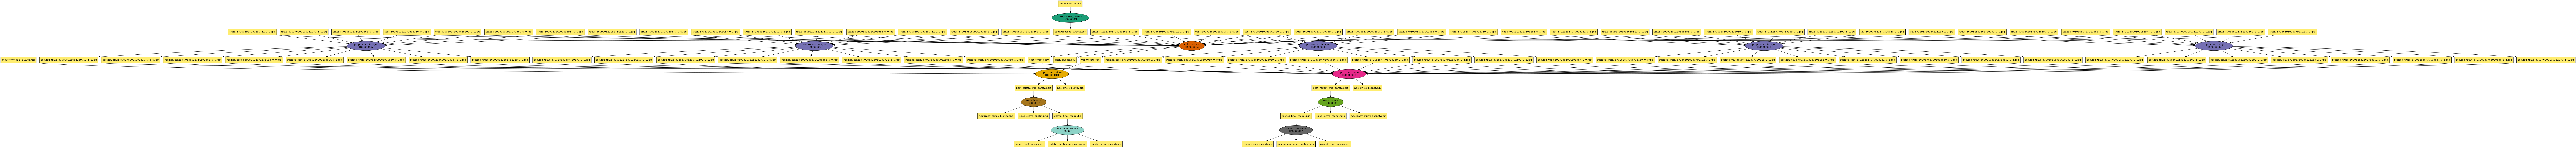

In [11]:
from IPython.display import Image
Image(filename='crisis-wf.png')